In [18]:
# Importing Libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix,  precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
# Load dataset
df = pd.read_csv("../DataSet/DataToTrainModel.csv")

# # Load and select top 20 features
# feature_importance_df = pd.read_csv("top_features.csv")
# top_features = feature_importance_df['Feature'].head(20).tolist()

In [20]:
# Remove the spaces before the column names
df.columns = df.columns.str.strip()

df.loc[:,'Label'].unique()

array(['BENIGN', 'DDoS', nan], dtype=object)

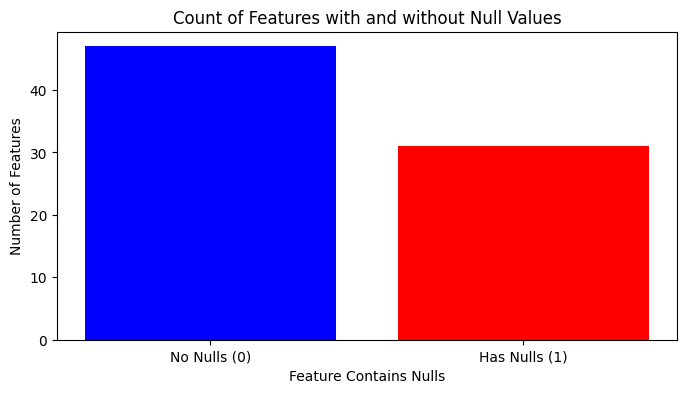

In [21]:
# Count features with and without missing values
null_counts = df.isna().any().value_counts()

# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(["No Nulls (0)", "Has Nulls (1)"], null_counts.values, color=['blue', 'red'])

# Set labels and title
plt.xlabel("Feature Contains Nulls")
plt.ylabel("Number of Features")
plt.title("Count of Features with and without Null Values")

# Show the plot
plt.show()

In [22]:
## Removing the null values
df.dropna(inplace=True)
data_f = df

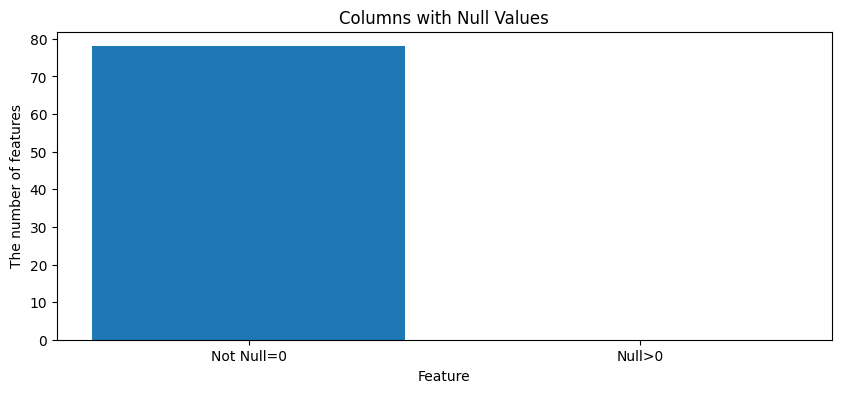

In [23]:
# Count the number of null values per column
null_counts = df.isna().sum()
null_counts = null_counts[null_counts > 0]  # Only keep columns with null values

# Create a bar plot
plt.figure(figsize=(10, 4))
plt.bar(['Not Null=0', 'Null>0'], [df.shape[1] - len(null_counts), len(null_counts)])

# Set the title and axis labels
plt.title('Columns with Null Values')
plt.xlabel('Feature')
plt.ylabel('The number of features')

# Show the plot
plt.show()


In [24]:


# Replace inf and -inf with NaN in the DataFrame
data_f = data_f.replace([float('inf'), float('-inf')], pd.NA)

# Check for NaN values
null_values = data_f.isnull().sum()


# To know the data types of the columns

(data_f.dtypes=='object')


Destination Port               False
Flow Duration                  False
Total Fwd Packets              False
Total Backward Packets         False
Total Length of Fwd Packets    False
                               ...  
Idle Mean                      False
Idle Std                       False
Idle Max                       False
Idle Min                       False
Label                           True
Length: 78, dtype: bool

In [25]:
# Convert the labels in the DataFrame to numerical values
data_f['Label'] = data_f['Label'].map({'BENIGN': 0, 'DDoS': 1})

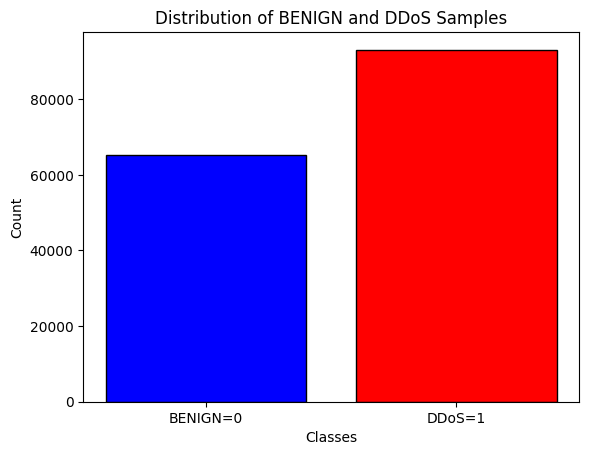

In [26]:


# Count class occurrences
class_counts = data_f['Label'].value_counts()

# Define colors for each class
colors = ['red', 'blue']

# Plot bar chart
plt.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black')

# Set x-ticks with class labels
plt.xticks([0, 1], labels=['BENIGN=0', 'DDoS=1'])

# Labels and title
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Distribution of BENIGN and DDoS Samples")

# Show the plot
plt.show()



In [27]:

data_f.fillna(data_f.mean(), inplace=True)  # Fill numeric NaNs with mean


# Verify that all NaNs are removed
print("Total NaN values after fix:", data_f.isna().sum().sum())  # Should print 0

Total NaN values after fix: 0


C:\Users\LEGION\AppData\Local\Temp\ipykernel_59916\2150566706.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_f.fillna(data_f.mean(), inplace=True)  # Fill numeric NaNs with mean


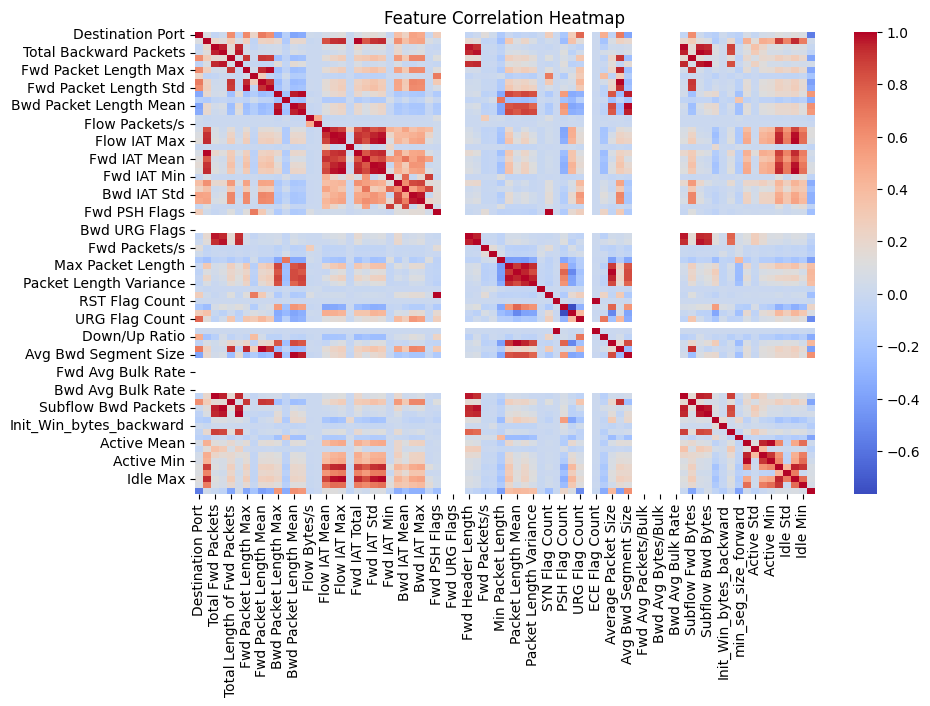

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_f.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

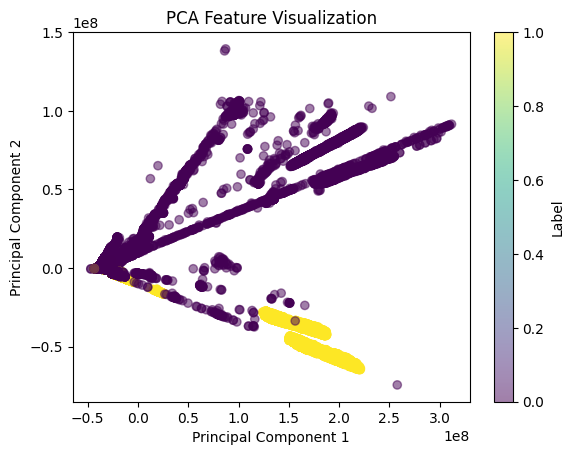

In [28]:

pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_f.drop(columns=['Label']))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=data_f['Label'], cmap='viridis', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Feature Visualization")
plt.colorbar(label='Label')
plt.show()



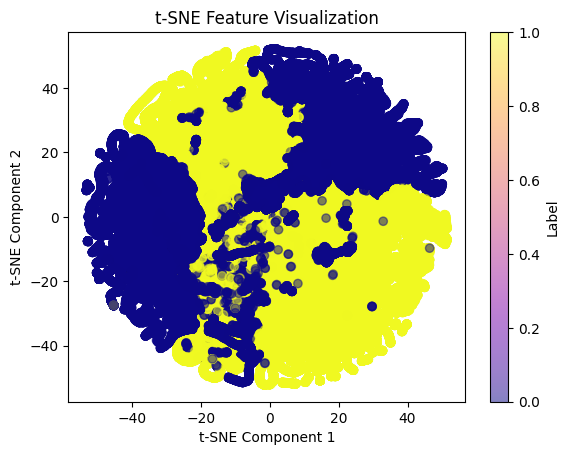

In [29]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(data_f.drop(columns=['Label']))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data_f['Label'], cmap='plasma', alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Feature Visualization")
plt.colorbar(label='Label')
plt.show()

In [29]:
# Select only top 20 features
# X = data_f[top_features]
X = data_f.drop('Label', axis=1)
y = data_f["Label"]

In [30]:
# Normalize the feature set
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
# Convert dataset into time-series sequences for LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    
    # Ensure y is a NumPy array
    y = np.array(y)
    
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        if i + time_steps < len(y):  # ✅ Prevents indexing beyond the array length
            ys.append(y[i + time_steps])
    
    return np.array(Xs), np.array(ys)

# Apply the fix
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=10)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

In [32]:
# Build LSTM Model
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1, activation="sigmoid")
])

# Compile and train the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

c:\Users\LEGION\Desktop\Sem-6-Coursework\THesis Project\Source\proj\RandomForest Model Training\Final Project\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9899 - loss: 0.0339 - val_accuracy: 0.9985 - val_loss: 0.0063
Epoch 2/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9990 - loss: 0.0047 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 3/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 4/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 5/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 6/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9996 - val_loss: 0.0032
Epoch 7/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9995 - val_loss: 0.0025
Epoch 8/10
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9996 - loss: 0

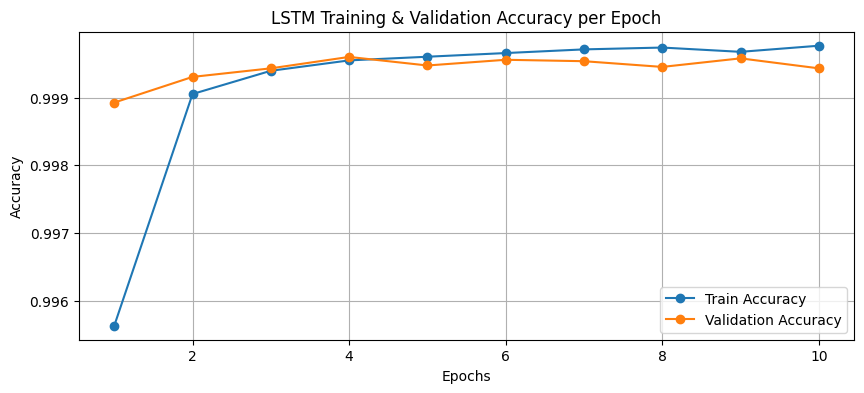

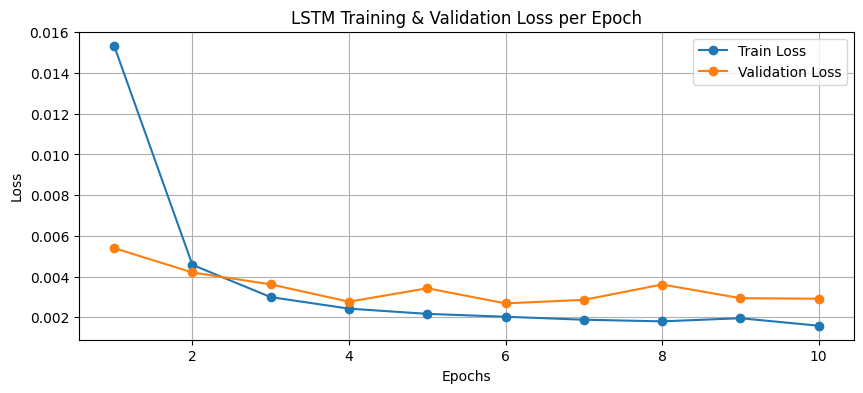

In [36]:

# Extract accuracy and loss from history
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Training & Validation Accuracy per Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, history.history['loss'], label='Train Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training & Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()


In [34]:
# Model Testing and Accuracy Evaluation
# Generate Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ LSTM Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

1484/1484 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
✅ LSTM Model Accuracy: 99.95%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19644
           1       1.00      1.00      1.00     27832

    accuracy                           1.00     47476
   macro avg       1.00      1.00      1.00     47476
weighted avg       1.00      1.00      1.00     47476



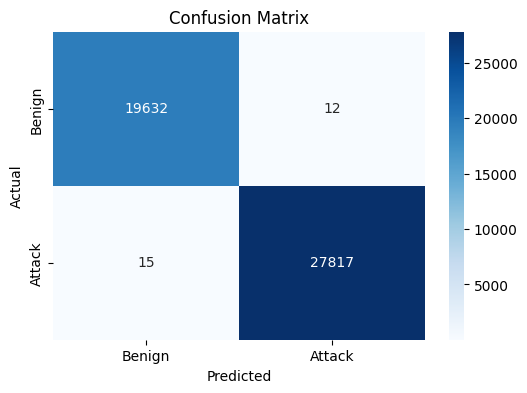

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19644
           1       1.00      1.00      1.00     27832

    accuracy                           1.00     47476
   macro avg       1.00      1.00      1.00     47476
weighted avg       1.00      1.00      1.00     47476



In [42]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

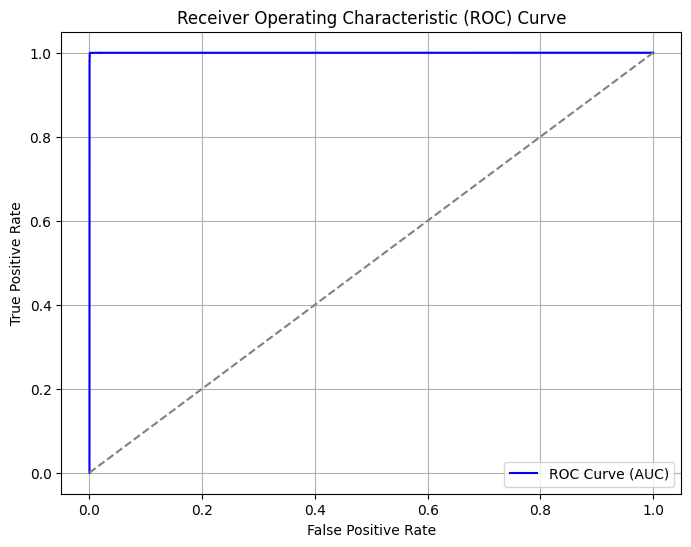

In [35]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

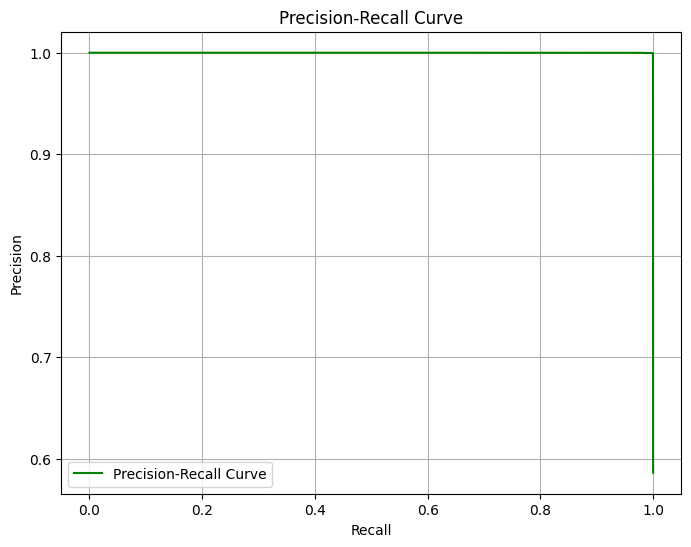

In [44]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Save trained model and scaler
model.save("./All_lstm_ddos_model.h5")
joblib.dump(scaler, "./All_scaler.pkl")

['./All_scaler.pkl']